# Substitution

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries

Most of the raw data processing is done in `data/phylo/Snakefile` — see that for details. 

## Raw Data

### Uricchio et al. Data

In [3]:
plt.show()

In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 3.5]
plt.rcParams['figure.dpi'] = 200

## Load B and R Maps

In [5]:
ratchet_pkl = '../data/bmaps/bgspy/bmap_hg37_ratchet_10000step_10000N_cds_utrs_phastcons.pkl'
ratchet_m = BGSModel.load(ratchet_pkl)

In [6]:
ratchet_m

## PhyloFit Branch Length Estimates

In [7]:
cols = ['chrom', 'start', 'end', 'branch_length', 'bl_nbases']
p = pd.read_csv('../data/phylo/phylofit_rates.bed', sep='\t', na_values='.', names=cols)

In [8]:
p.head()

,chrom,start,end,branch_length,bl_nbases
0,chr1,1059994,1095749,0.010402,72265
1,chr1,1283738,1308299,0.006782,52319
2,chr1,1564773,1623511,0.010483,178850
3,chr1,1626991,1655940,0.006026,63570
4,chr1,1752959,1789083,0.008125,86103


[]

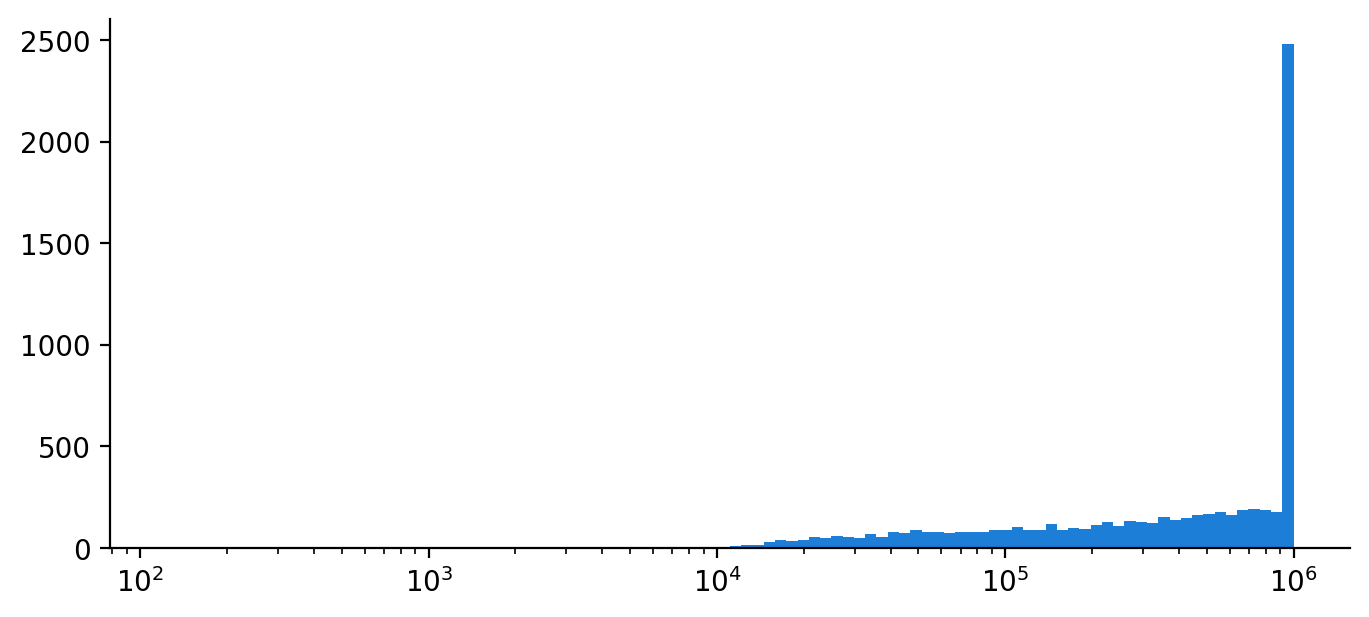

In [9]:
plt.hist(*logbins(p['bl_nbases'], 100))
plt.semilogx()

Esemble's data includes alignments only up to a megabase in length, hence the over-representation of this bin.

In [10]:
p['bl_nbases'].max()

1000000

## Analysis of Predicted Ratchet Rates for CDS/UTRS/PhastCons Model

In [11]:
cols = [
    "chrom",
    "start",
    "end",
    "gene_id",
    "n_nonsyn",
    "n_syn",
    "fixed_nonsyn",
    "fixed_syn",
    "dnDs",
    "total_fixed",
    "len",
    "cai",
    "gc",
    "gc3",
    "syn_prop",
    "nonsyn_prop",
    "total_prop",
    "dNdS",
    "r",
    "r_nbases",
    "branch_length",
    "bl_nbases",
]

d = pd.read_csv('../data/phylo/urrichio_data_merged.bed', sep='\t', na_values='.', names=cols)
d['width'] = d['end'] - d['start']

In [12]:
d.head()

,chrom,start,end,gene_id,n_nonsyn,n_syn,fixed_nonsyn,fixed_syn,dnDs,total_fixed,...,gc3,syn_prop,nonsyn_prop,total_prop,dNdS,r,r_nbases,branch_length,bl_nbases,width
0,chr1,923923,944575,ENSG00000187634,28,21,8,4,2.000000,12,...,0.832938,0.001580,0.003160,0.004739,2.000000,2.502833e-08,4658,NaN,NaN,20652
1,chr1,944203,959309,ENSG00000188976,31,32,4,8,0.500000,12,...,0.794393,0.003560,0.001780,0.005340,0.500000,4.107783e-08,2950,NaN,NaN,15106
2,chr1,960584,965719,ENSG00000187961,11,28,0,8,0.000000,8,...,0.838006,0.004154,0.000000,0.004154,0.000000,4.222435e-08,2776,NaN,NaN,5135
3,chr1,966482,975865,ENSG00000187583,47,19,0,3,0.000000,3,...,0.801964,0.001637,0.000000,0.001637,0.000000,3.766140e-08,3800,NaN,NaN,9383
4,chr1,975198,982117,ENSG00000187642,31,22,11,3,3.666667,14,...,0.681013,0.001266,0.004641,0.005907,3.666667,4.105993e-08,4203,NaN,NaN,6919


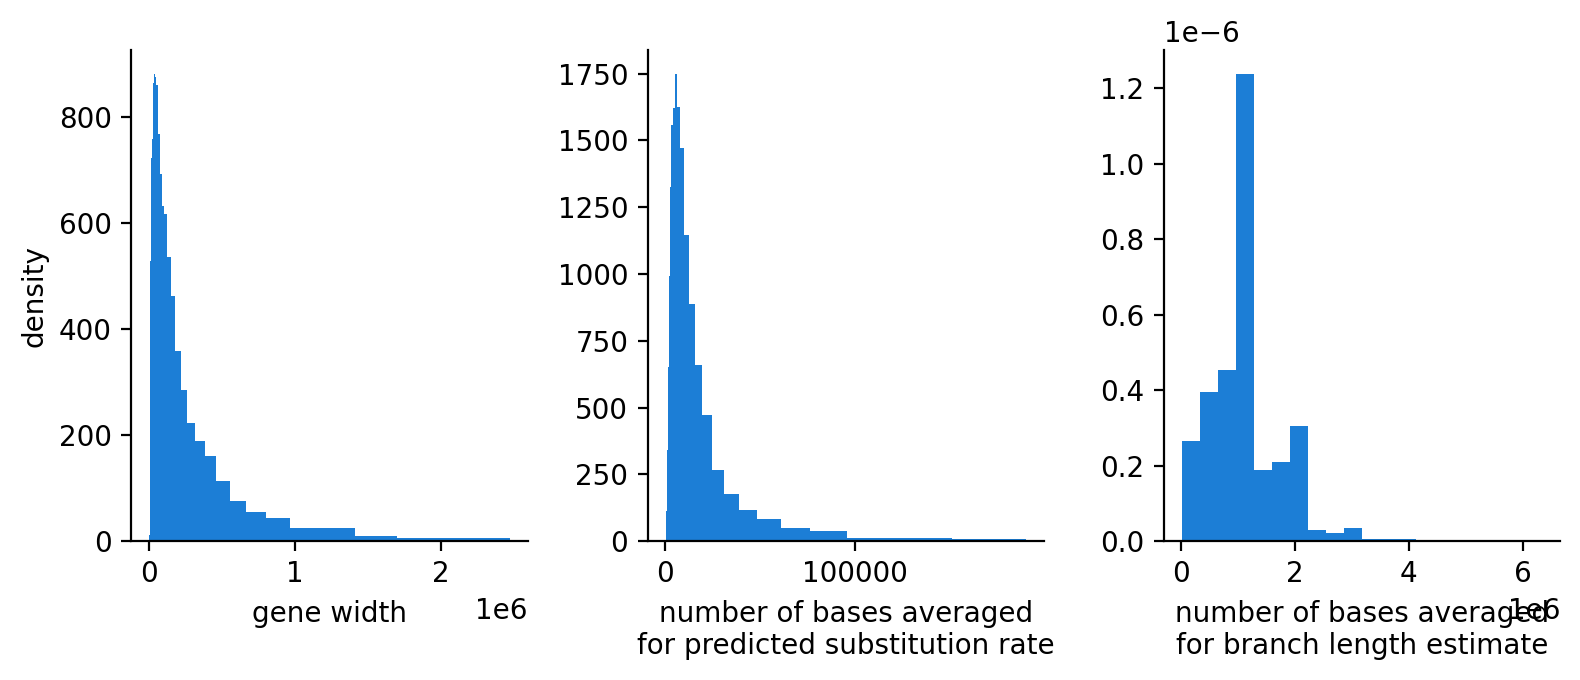

In [13]:
# width of genes, number of bases averaged for ratchet estimate, 
# number of bases averaged for 

fig, ax = plt.subplots(ncols=3)


ax[0].hist(*logbins(d['width'], 50, density=True))
ax[1].hist(*logbins(d['r_nbases'], 30, density=True))
_ = ax[2].hist(d['bl_nbases'], 20, density=True)
ax[0].set_ylabel('density')
ax[0].set_xlabel('gene width')
ax[1].set_xlabel('number of bases averaged\nfor predicted substitution rate')
ax[2].set_xlabel('number of bases averaged\nfor branch length estimate')
plt.tight_layout()

In [14]:
d['bl_nbases'].max()

6336248.0

Text(0.5, 0, 'predicted substitution rate')

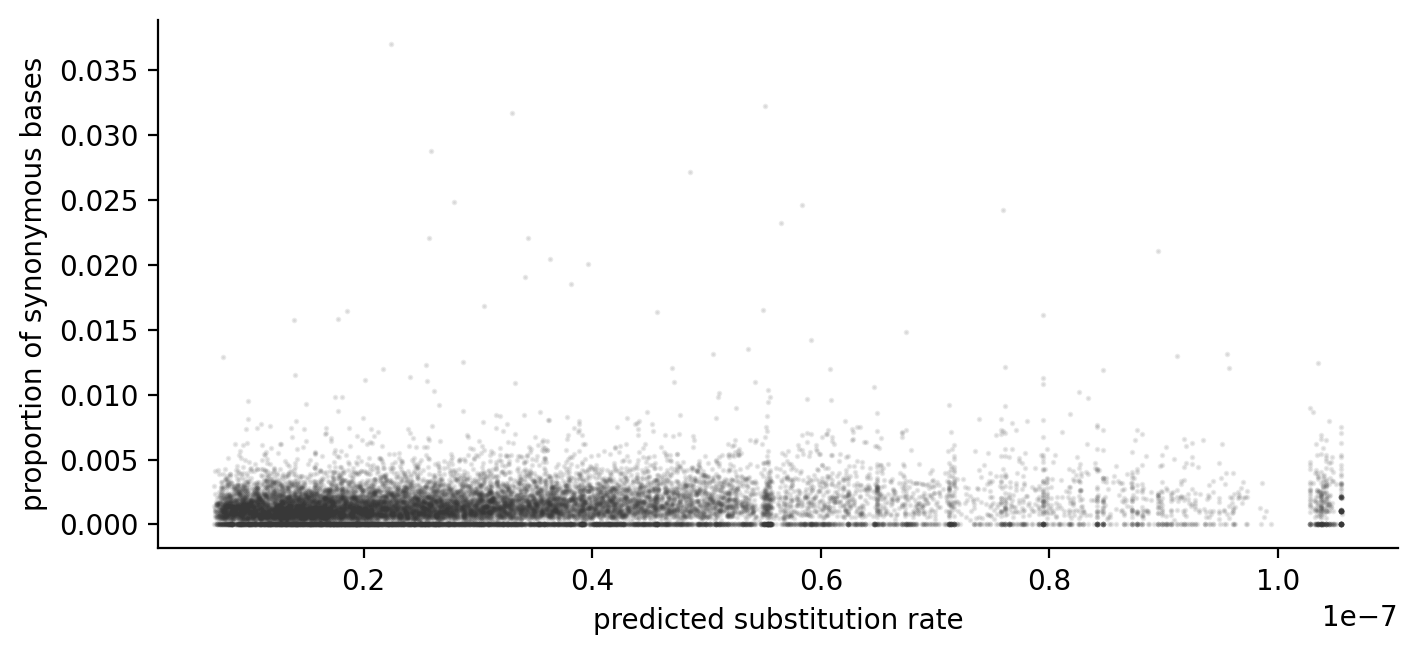

In [15]:
fig, ax = plt.subplots()
ax.scatter(d['r'], d['syn_prop'], c='0.22', s=1, alpha=0.1)
ax.set_ylabel('proportion of synonymous bases')
ax.set_xlabel('predicted substitution rate')

In [16]:
ax.get_xlim(), ax.get_ylim()

((1.9998317254499997e-09, 1.1051195860355e-07),
 (-0.0018518518518518502, 0.03888888888888885))

In [17]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [18]:
x, syn_prop, nonsyn_prop, branch_length = d['r'], d['syn_prop'], d['nonsyn_prop'], d['branch_length']

nbins = 100
dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))


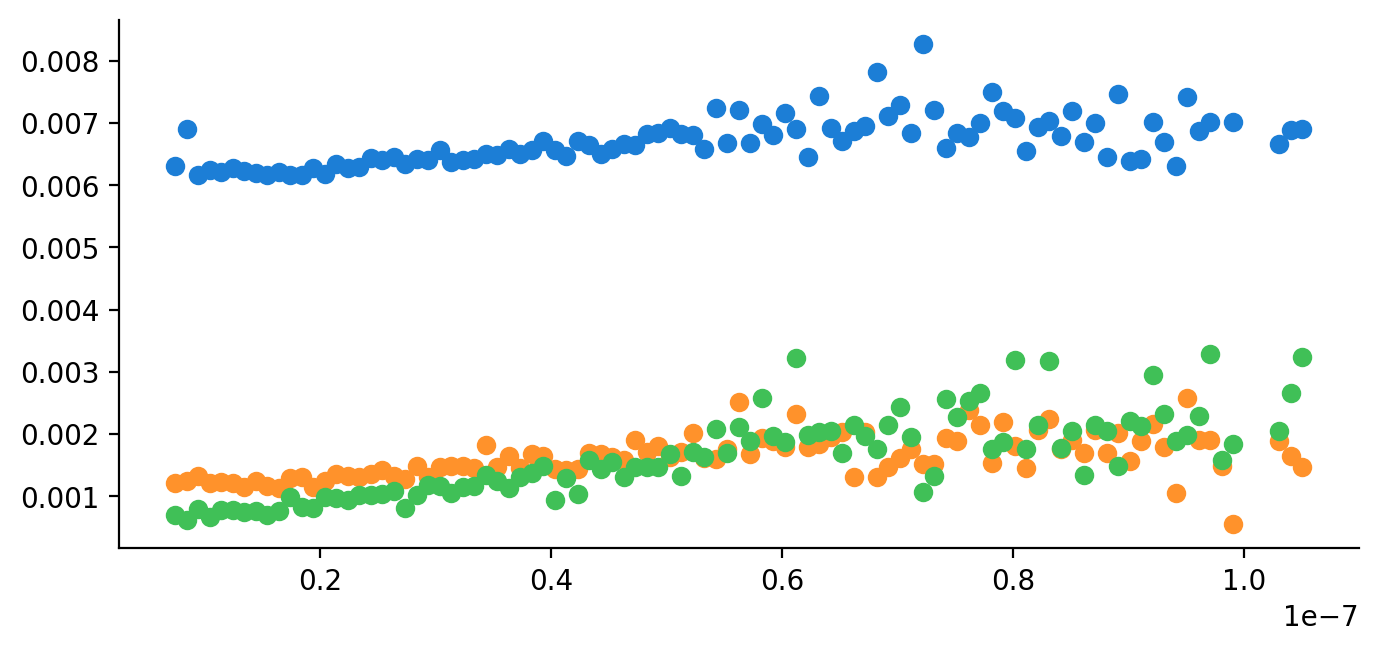

In [20]:
plt.scatter(*bin2pairs(binned_statistic(x, branch_length, np.nanmean, bins=cutbins(x, 100))))
plt.scatter(*bin2pairs(binned_statistic(x, syn_prop, np.nanmean, bins=cutbins(x, 100))))
plt.scatter(*bin2pairs(binned_statistic(x, nonsyn_prop, np.nanmean, bins=cutbins(x, 100))))

In [ ]:
cols = ['chrom', 'start', 'end', 'feature', 'R', 'r', 'seglen']

rd = pd.read_csv('../data/phylo/ratchet_data.bed', sep='\t', names=cols)
                     
rd.groupby('feature')['r'].mean()

In [67]:
nbins = 100

dns = binned_summaries(x, nonsyn_prop, nbins)
ds = binned_summaries(x, syn_prop, nbins)
dbl = binned_summaries(x, branch_length, nbins)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [68]:
min_n = 0
dnsx = dns.loc[dns['n'] > min_n]
dsx = ds.loc[ds['n'] > min_n]


Text(0, 0.5, 'proportion substitutions')

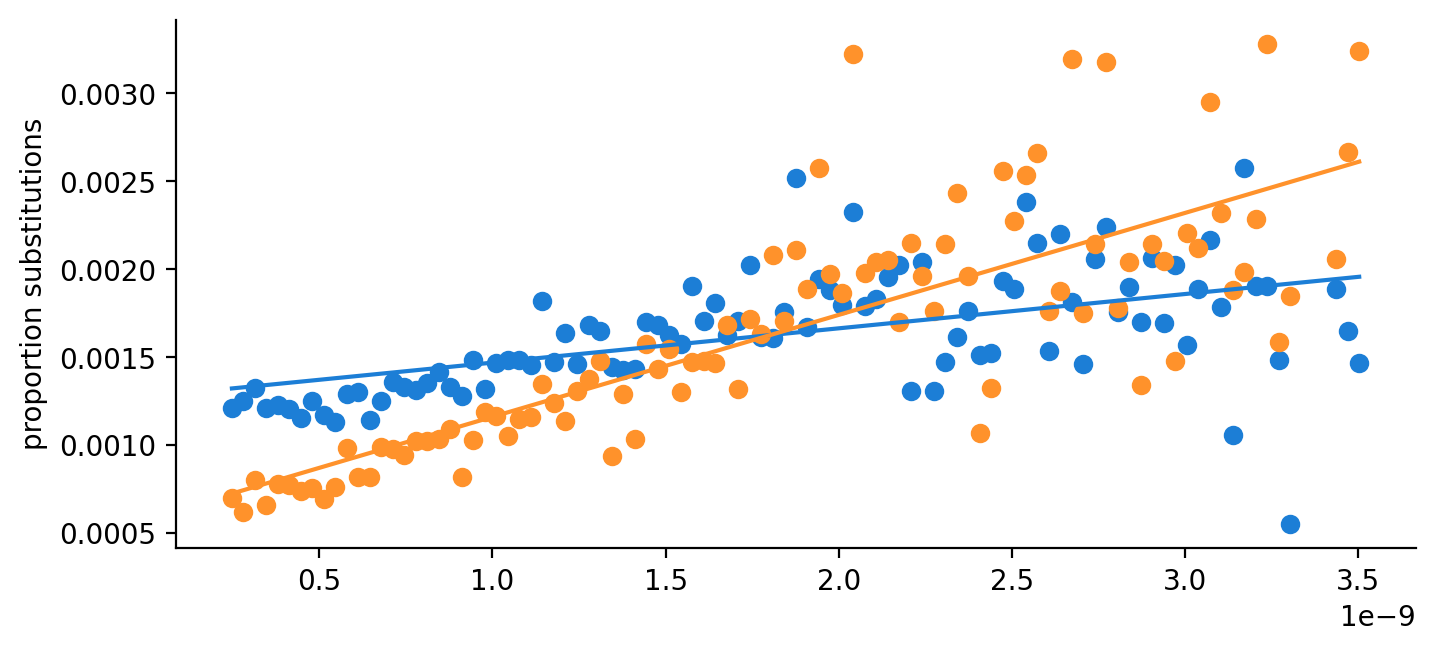

In [69]:
syn_lfit = stats.linregress(dsx['midpoint']/gen, dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint']/gen, dnsx['mean'])

fig, ax = plt.subplots()
ax.scatter(dsx['midpoint']/gen, dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)/gen
ax.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

ax.scatter(dnsx['midpoint']/gen, dnsx['mean'], label='non-syn')
ax.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)
ax.set_ylabel('proportion substitutions')

In [72]:
def JC69(dist):
    # distance
    return 0.75 - 0.75*np.exp(-4/3 * dist)

def JC69_parametric(lambda_d, beta, T, a):
    dist = a*T + T*beta*lambda_d
    return 0.75 - 0.75*np.exp(-4/3 * dist)

In [73]:
binned_r, binned_bl = dbl['midpoint'].values, dbl['mean'].values
r, bl = d['r'].values, d['branch_length'].values

In [74]:
def fit_JC69(predicted, subrate, gen_time=30):
    lambda_d, y = predicted/gen_time, subrate
    keep = np.isfinite(lambda_d) & np.isfinite(y)
    lambda_d, y = lambda_d[keep], y[keep]
    return lambda_d, y, curve_fit(JC69_parametric, lambda_d, y, p0=(0.02, 6e6, 0))

bin_xx, bin_yy, bin_fit = fit_JC69(binned_r, binned_bl)
xx, yy, fit = fit_JC69(r, bl)

In [75]:
bin_fit

(array([1.18910055e-02, 2.20949172e+07, 2.83833969e-10]),
 array([[ 4.45246530e+03, -8.26519821e+12,  1.06278951e-04],
        [-8.26519821e+12,  1.53428487e+22, -1.97287691e+05],
        [ 1.06278951e-04, -1.97287691e+05,  2.53684526e-12]]))

In [76]:
fit

(array([1.52915621e-02, 1.96246227e+07, 3.14601159e-10]),
 array([[ 2.56070379e+03, -3.29059661e+12,  5.26824320e-05],
        [-3.29059661e+12,  4.22853516e+21, -6.76988226e+04],
        [ 5.26824320e-05, -6.76988226e+04,  1.08385775e-12]]))

(0.003, 0.012)

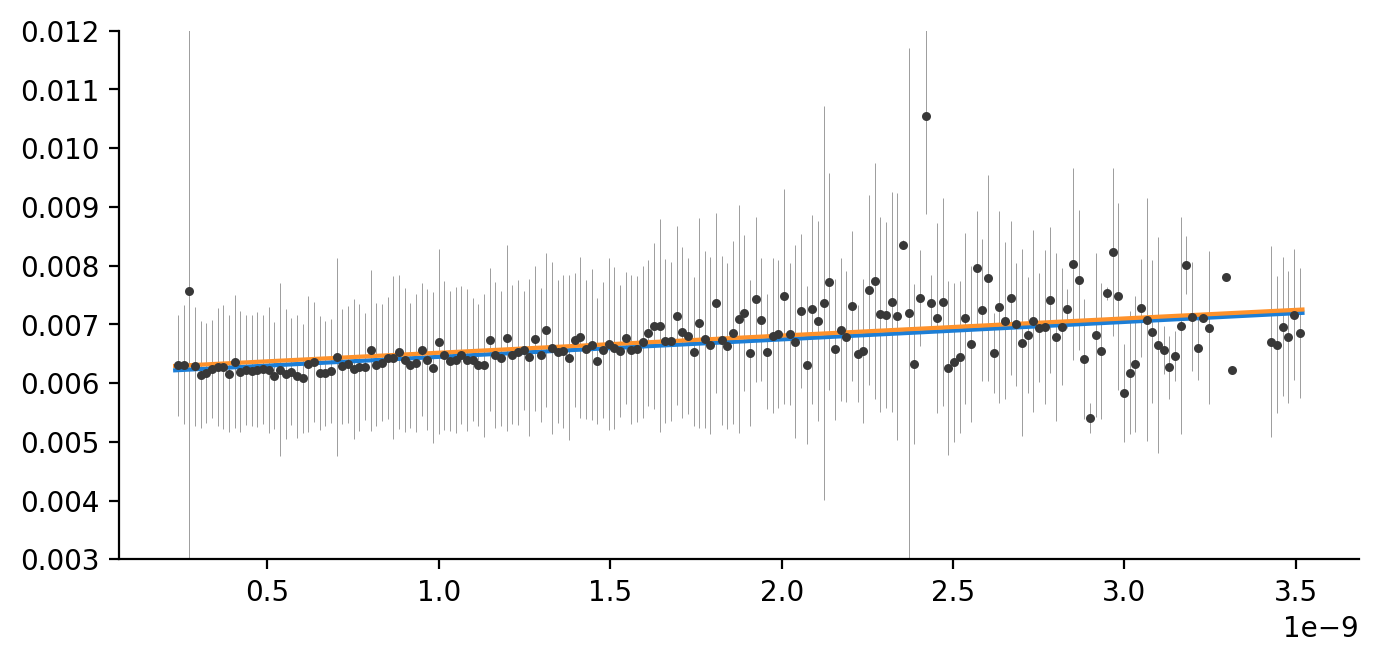

In [66]:
fig, ax = plt.subplots()
ax.scatter(dbl['midpoint'].values/gen, dbl['mean'].values, c='0.22', s=5, alpha=1, zorder=10)
#ax.set_ylim(0, 0.02)
ax.errorbar(dbl['midpoint']/gen, dbl['mean'], dbl['sd'], fmt='none', c=error_col, elinewidth=0.2)

rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, JC69_parametric(rate_grid, *fit[0]))
ax.plot(rate_grid, JC69_parametric(rate_grid, *bin_fit[0]))

ax.set_ylim(0.003, 0.012)

In [77]:
def print_subfit(fit, gen_time=30):
    beta, T, a = fit[0]
    info = (f"intercept (λ_B T), a = {a:.3g}\n"
            f"  λ_B = {a / T:.3g} \n"
            f"T = {T/1e6:.4g} (Mya)\n"
            f"β = {beta:.3g}")
    print(info)
    
print_subfit(fit)

intercept (λ_B T), a = 3.15e-10
  λ_B = 1.6e-17 
T = 19.62 (Mya)
β = 0.0153


In [78]:
print_subfit(bin_fit)

intercept (λ_B T), a = 2.84e-10
  λ_B = 1.28e-17 
T = 22.09 (Mya)
β = 0.0119


In [ ]:
xx, yy = 0.02*dblx['midpoint']/gen,  dblx['mean']/ (split)


fig, ax = plt.subplots()
ax.scatter(xx, yy, label='syn')
rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, bl_lfit.intercept + bl_lfit.slope*rate_grid)

In [ ]:
min_n = 50
dblx = dbl.loc[dbl['n'] > min_n]


xx, yy = 0.02*dblx['midpoint']/gen,  dblx['mean']/ (split)

bl_lfit = stats.linregress(xx, yy)

fig, ax = plt.subplots()
ax.scatter(xx, yy, label='syn')
rate_grid = np.linspace(xx.min(), xx.max(), 100)
ax.plot(rate_grid, bl_lfit.intercept + bl_lfit.slope*rate_grid)
ax.axline((ax.get_xlim()[0], ax.get_ylim()[0]), slope=1, c='0.22', linestyle='dashed')
ax.set_ylabel('proportion substitutions')

In [ ]:
bl_lfit

In [ ]:
fig, ax = plt.subplots()

error_col = '0.33'
ax.scatter(dbl['midpoint']*T*split, dbl['mean'], c=error_col, s=5)
ax.errorbar(dbl['midpoint']*T*split, dbl['mean'], dbl['sd'], fmt='none', c=error_col)
#ax.axline((0, 0), slope=1)
#ax.grid()
ax.set_xlim(0, 0.05)

In [ ]:
cols = ('chrom', 'start', 'end', 'R', 'r', 'r_nbases')
rdf = pd.read_csv('../data/phylo/ratchet_rates_binned_1000000.bed', sep='\t', names=cols, na_values='.')

In [ ]:
pf = pd.read_csv('../data/phylo/phylofit_rates_binned_1000000.bed', sep='\t',
                 na_values='.',
                 names=('chrom', 'start', 'end', 'subrate', 'nbases'))



In [ ]:
chrom = 'chr2'
rdfx = rdf.loc[(rdf['chrom'] == chrom)]
pfx = pf.loc[pf['chrom'] == chrom]

fig, ax = plt.subplots()
ax.plot(rdfx.start, rdfx['r'])

ax2 = ax.twinx()
ax2.plot(pfx['start'], pfx['subrate'], c='r')

In [ ]:
min_n = 0


plt.scatter(dnsx['midpoint'], dnsx['mean'], label='non-syn')

plt.scatter(dsx['midpoint'], dsx['mean'], label='syn')

syn_lw = lowess(syn_prop, x, frac=1/50)
#plt.plot(*syn_lw.T)

plt.legend()

In [ ]:
dblx = dbl.loc[dbl['n'] > min_n]
plt.scatter(dblx['midpoint'], dblx['mean'])

$$
S = \lambda_g t_y g
$$



In [ ]:
syn_lfit = stats.linregress(dsx['midpoint'], dsx['mean'])
nonsyn_lfit = stats.linregress(dnsx['midpoint'], dnsx['mean'])

plt.scatter(dsx['midpoint'], dsx['mean'], label='syn')
rate_grid = np.linspace(dsx['midpoint'].min(), dsx['midpoint'].max(), 100)
plt.plot(rate_grid, syn_lfit.intercept + syn_lfit.slope*rate_grid)

plt.scatter(dnsx['midpoint'], dnsx['mean'], label='non-syn')
plt.plot(rate_grid, nonsyn_lfit.intercept + nonsyn_lfit.slope*rate_grid)


In [ ]:
gen_time = 30 # years / gen 


d = ds
dx = d.loc[(d['n'] > 30) & (d['midpoint'] < 3.42e-7)]

#dx = d.loc[(d['n'] > 30) & (d['midpoint'] < 3.5e-7) & (d['midpoint'] > 3.409e-7)]
midpoint_gen = dx['midpoint'] / gen_time



bl_lfit = stats.linregress(midpoint_gen, dx['mean'])


plt.scatter(midpoint_gen, dx['mean'], label='syn')

rate_grid = np.linspace(midpoint_gen.min(), midpoint_gen.max(), 100)

plt.plot(rate_grid, rate_grid*bl_lfit.slope + bl_lfit.intercept)

In [ ]:
bl_lfit

In [ ]:
bl_lfit.slope

In [ ]:
def JC69(r, t):
    # distance
    return r * t
    #return 0.75 - 0.75*np.exp(-4/3 * r*t)


In [ ]:
plt.plot(rate_grid, JC69(rate_grid, 4.5e6 / 30))

In [ ]:


fig, ax = plt.subplots()


ax2 = ax.twinx()
srate_bins = stats.binned_statistic(x, d['nonsyn_prop'], 
                                    statistic=np.nanmean,
                                    bins=bins)

ax.scatter(bin2midpoints(srate_bins), srate_bins.statistic, c='r', label='Urrichio et al. non-syn')

srate_bins = stats.binned_statistic(x, d['syn_prop'], 
                                    statistic=np.nanmean,
                                    bins=bins)
ax.scatter(bin2midpoints(srate_bins), srate_bins.statistic, c='0.77', label='Urrichio et al. syn')



srate_bins = stats.binned_statistic(x, d['branch_length'], 
                                    statistic=np.nanmean,
                                    bins=bins)
ax2.scatter(bin2midpoints(srate_bins), srate_bins.statistic, label='phylofit')


ax2.set_ylabel("branch length")
ax.set_ylabel("proportion of substitutions")
ax.set_xlabel("predicted substitution rate")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax.legend(h1 + h2, l1 + l2, loc='upper left')
#ax.set_xlim(3.407e-7, 3.45e-7)